# Regression models

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error# MSE
from statsmodels.stats.diagnostic import het_goldfeldquandt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge # Ridge regression 
from sklearn.linear_model import Lasso # Lasso regression
import warnings

#Turing off the warnings
warnings.filterwarnings('ignore')

In [2]:
#Setting seed for replicability 
seed = 500

#Loading the data - from previous code 
df_cleaned = pd.read_csv('data_cleaned.csv')
df_cleaned.dtypes

Unnamed: 0                                 int64
id                                         int64
name                                      object
picture_url                               object
host_id                                    int64
host_since                                object
host_response_rate                       float64
host_acceptance_rate                     float64
neighbourhood_cleansed                    object
latitude                                 float64
longitude                                float64
room_type                                 object
accommodates                               int64
bathrooms_text                            object
beds                                     float64
price                                    float64
minimum_nights                             int64
maximum_nights                             int64
availability_90                            int64
review_scores_rating                     float64
calculated_host_list

Selecting columns for the model 

We selected numerical variables and categorical variables with a maximum
of 4 categories for easier computation. We also considered the importance of variables
(for example, host ID is not relevant).

In [3]:
df_model = df_cleaned[["Lprice","host_response_rate","host_acceptance_rate","accommodates","beds",
                       "minimum_nights","maximum_nights","availability_90","review_scores_rating",
                        "calculated_host_listings_count","reviews_per_month","Hotel room","Private room","Shared room","bathrooms_cislo",
                        "5 to 10","less than 5","host_response_time_within a day","host_response_time_within a few hours",
                        "host_response_time_within an hour","neighborhood_overview_1","host_location_1",
                        "host_about_1","host_is_superhost_t","host_has_profile_pic_t","host_identity_verified_t","has_availability_t","instant_bookable_t"]]

#Command to recode from True False to 1, 0 - encoding:
df_model = df_model.astype(int)


Splitting the data into training and testing sets

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    df_model.drop(['Lprice'], axis=1),  
    df_model[['Lprice']],  
    test_size=0.2,  
    random_state=seed
)

### Model 1
Creating linear regression model using the package sklearn

In [5]:
sklearn_model = LinearRegression()

#Fitting the model
sklearn_model.fit(x_train, y_train)

#Parameters of the model with first value being the intercept
params = np.append(sklearn_model.intercept_, sklearn_model.coef_)
params

#R2 value
sklearn_model_R2=sklearn_model.score(x_train, y_train)
#R2 value is 0,2957. The model is therefore able to explain around 30 % of variability of the dataset

#Predict values for the x_test set
y_pred = sklearn_model.predict(x_test)

#Calculate RMSE for test data
rmse_model_1 =mean_squared_error(y_test, y_pred, squared=False)
rmse_model_1 #This model's RMSE is 0,5534

#Transforming do 1-dimensional arrays
y_pred = y_pred.flatten()
residuals_1=y_test.values.ravel() - y_pred


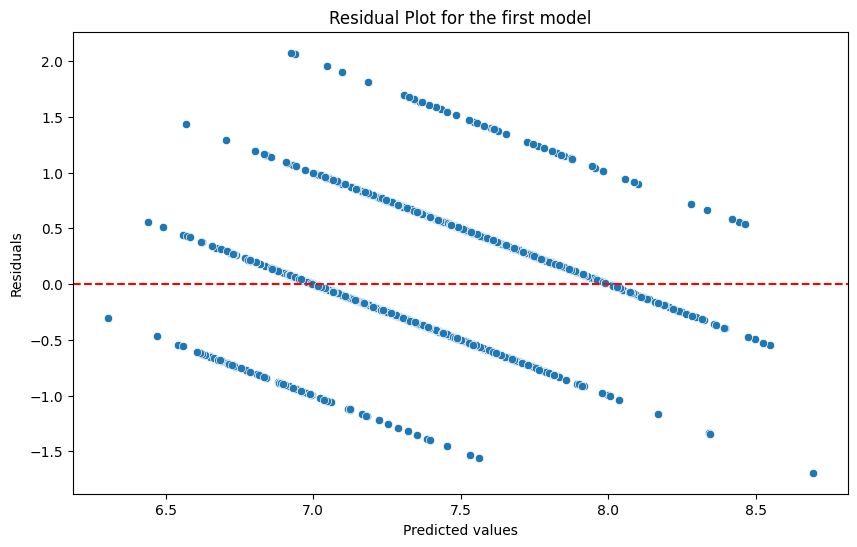

In [6]:
#Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals_1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for the first model')
plt.show()

Clearly there are some nonlinear relationships in the data, we should instead choose tree based models instead


### Model 2

Crossvalidation - first method

In [7]:
sklearn_model = LinearRegression()
#Defining the grid
param_grid = {
    'fit_intercept': [True, False],  #Include intercept in the model?
    'positive': [True, False],      #Predict only positive values for the explained variable?
    'copy_X': [True, False]           #Copy x before each set?
}

#Launching the GridSearchCV with sklearn_model as estimator
grid_search = GridSearchCV(sklearn_model, param_grid, cv=10)

#Fitting the grid search to the data
grid_search.fit(x_train, y_train)

#Best parameters and score
print("Best parameters:", grid_search.best_params_)
#best parameters are: Copy x before yes, fit the intercept and dont fit only positive values
print("Best score:", grid_search.best_score_)
#Best score achieved is 0,2845
grid_search_R2=grid_search.best_score_

#Predict values for the x_test set
y_pred_cv = grid_search.predict(x_test)

#Calculate RMSE for test data
rmse_model_2 =mean_squared_error(y_test, y_pred_cv, squared=False)
rmse_model_2 #This model's RMSE is 0,553

#Transforming do 1-dimensional arrays
y_pred_cv = y_pred_cv.flatten()
residuals_2=y_test.values.ravel() - y_pred_cv


Best parameters: {'copy_X': True, 'fit_intercept': True, 'positive': False}
Best score: 0.28448793388889215


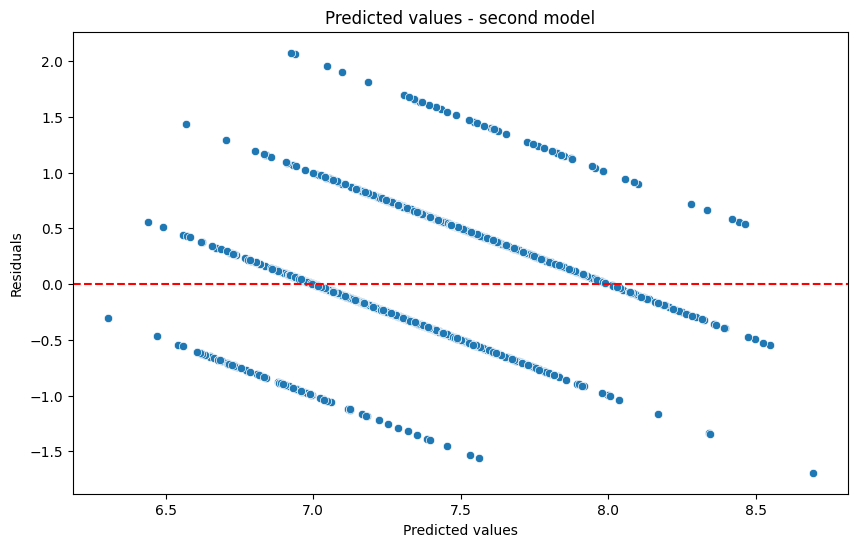

In [8]:
#Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_cv, y=residuals_2)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Predicted values - second model')
plt.show()

Clearly there are some nonlinear relationships in the data, we should instead choose tree based models instead


### Model 3

Crossvalidation - second method 

In [9]:
#Creating crossvalidation 
folds = KFold(n_splits = 5, shuffle = True, random_state = 500)

#Specifying hyperparameters - range of features to select
hyper_params = [{'n_features_to_select': list(range(1, 28))}]

#RFE - method to eliminate unimportant features
rfe = RFE(sklearn_model)

#Launching the GridSearchCV with rfe as estimator
model_cv = GridSearchCV(estimator = rfe,param_grid = hyper_params,scoring= 'r2',cv = folds,verbose = 1,return_train_score=True)

#fitting the model
model_cv.fit(x_train, y_train) 

#Best parameters and score
print("Best parameters:", model_cv.best_params_)
#best parameters are to select 27 features

print("Best score:", model_cv.best_score_)
#Best score achieved is 0,2858

model_cv_R2=model_cv.best_score_

#Predict values for the x_test set
y_pred_cv_2 = model_cv.predict(x_test)

#Calculate RMSE for test data
rmse_model_3 =mean_squared_error(y_test, y_pred_cv_2, squared=False)
rmse_model_3 #This model's RMSE is 0,553


#Transforming do 1-dimensional arrays
y_pred_cv_2 = y_pred_cv_2.flatten()
residuals_3=y_test.values.ravel() - y_pred_cv_2

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'n_features_to_select': 27}
Best score: 0.2858804088282559


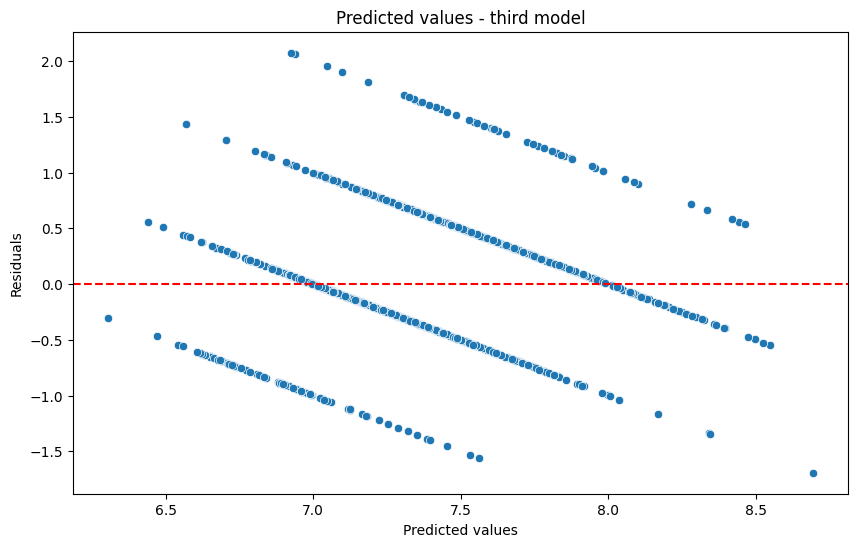

In [10]:
#Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_cv_2, y=residuals_3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Predicted values - third model')
plt.show()

Clearly there are some nonlinear relationships in the data, we should instead choose tree based models instead


#### Creating model using statmodels package for more information

In [11]:
#Adding a constant for training and testing data
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)
 
#Fitting the model
linear_model = sm.OLS(y_train, X_train).fit()

#Displaying model details
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Lprice   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     87.24
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:41:15   Log-Likelihood:                -4644.6
No. Observations:                5638   AIC:                             9345.
Df Residuals:                    5610   BIC:                             9531.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

The R2 is 0,29. Model is statistically significant (F-test p value is 0,0)

Durbin- watson statistics is around 2, therefore there should be no autocorrelation in the model

Jarque-bera test of normality suggests, that the data is not normally distributed

The condition number is large, 2.21e+04. This might indicate that there is strong multicollinearity or other numerical problems.


In [12]:
# Predictions on the testing set
y_pred_linear = linear_model.predict(X_test)

#Testing heteroskedasticity using the goldfeld-quandt test
gq_statistic, gq_p_value, _ = het_goldfeldquandt(linear_model.resid, linear_model.model.exog)
gq_p_value

0.5257344043974304

Goldfeld-quandt test is not statistically significant, therefore heteroskedasticity is not present in the model

### Model 4

Ridge regression

In [13]:
#Standardization of features using standardscaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_train)

#Centering the y variable
y_center = y_train - np.mean(y_train)

#Defnining the ridge model
ridge_model = Ridge(
  alpha = 5, 
  fit_intercept = True,
  # normalize = False, 
  random_state = seed) 

#Fitting the model
ridge_model.fit(X_scaled, y_center)

#Resulting coeffiecients
ridge_model.coef_
ridge_model.intercept_

#R2 score
ridge_R2=ridge_model.score(X_scaled, y_center)
#R2 score for the ridge model is 0,2957. So far the best model based on R2.

# Make predictions on the test data
y_pred = ridge_model.predict(x_test)

#Calculating RMSE for test data 
rmse_model_ridge = mean_squared_error(y_test, y_pred, squared=False)
rmse_model_ridge
#However the rmse is biggest of all the models -> 8,058

y_pred = y_pred.flatten()
residuals_4=y_test.values.ravel() - y_pred

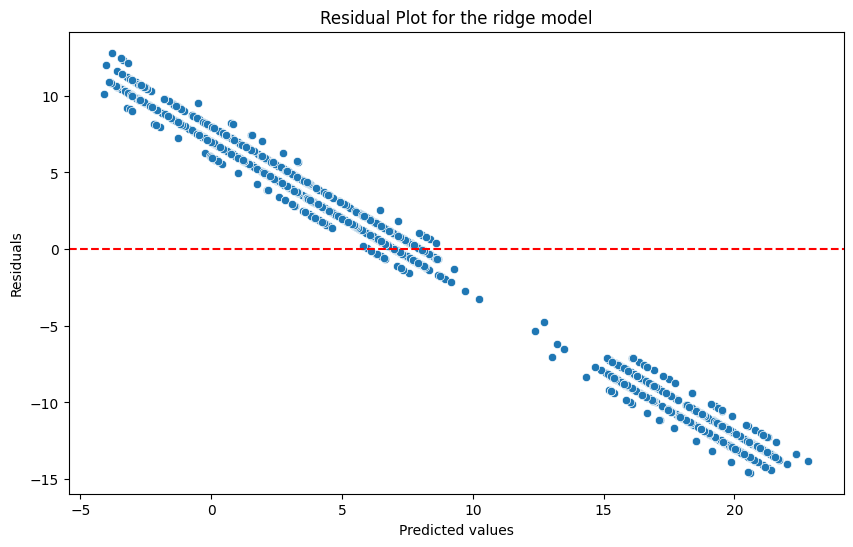

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals_4)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for the ridge model')
plt.show()

Clearly there are some nonlinear relationships in the data, we should instead choose tree based models instead

### Model 5

Lasso regression

In [15]:
#Defnining the lasso model
lasso_model = Lasso(
  alpha = 5, 
  fit_intercept = True, #chceme aby zůstalo beta nula
  #data leak = předám informaci z trénovacích dat kterou ještě nemám vědět?
  random_state = seed) 

#Fitting the model
lasso_model.fit(X_scaled, y_center)

#Resulting coeffiecients
lasso_model.coef_
lasso_model.intercept_
#we can see that the model chose null coefficient and only models the data via intercept

# R2 score
lasso_R2=lasso_model.score(X_scaled, y_center)
# therefore the R2 is 0 and model unsuable

#Make predictions on the test data
y_pred = lasso_model.predict(x_test)

#Calculate RMSE for test data 
rmse_model_lasso = mean_squared_error(y_test, y_pred, squared=False)
rmse_model_lasso
#Interestingly this model has lower RMSE than the ridge one.

y_pred = y_pred.flatten()
residuals_5=y_test.values.ravel()-y_pred

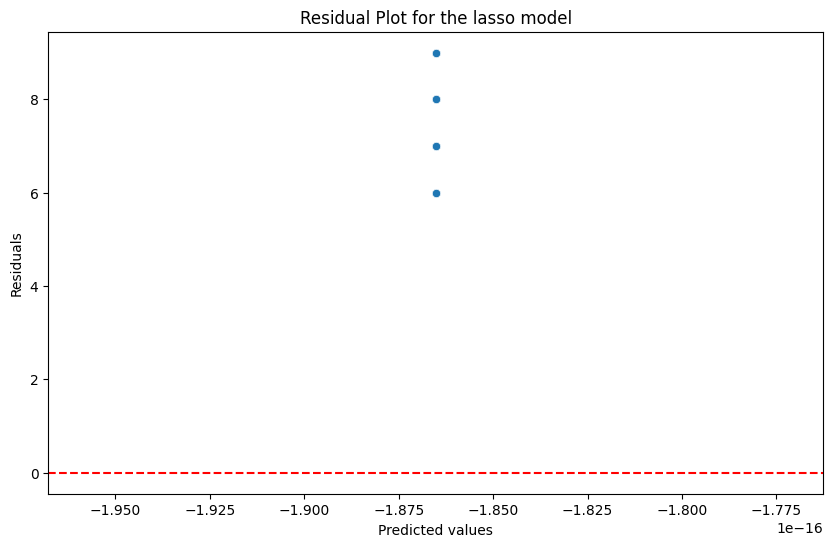

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals_5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot for the lasso model')
plt.show()


Clearly there are some nonlinear relationships in the data, we should instead choose tree based models instead

## All results combined

In [17]:
results_df = pd.DataFrame(columns=['Model', 'R2', 'RMSE'])
results_df.loc[0] = ['sklearn_model', sklearn_model_R2, rmse_model_1]
results_df.loc[1] = ['GridSearchCV', grid_search_R2, rmse_model_2]
results_df.loc[2] = ['RFE + GridSearchCV', model_cv_R2, rmse_model_3]
results_df.loc[3] = ['ridge_model', ridge_R2, rmse_model_ridge]
results_df.loc[4] = ['lasso_model', lasso_R2, rmse_model_lasso]
print(results_df)

                Model        R2      RMSE
0       sklearn_model  0.295718  0.553409
1        GridSearchCV  0.284488  0.553409
2  RFE + GridSearchCV  0.285880  0.553409
3         ridge_model  0.295717  8.057776
4         lasso_model  0.000000  7.395322


The stamodels model is omitted, because it is identical with the sklearn_model.

We can see that the non-regularized regression models have the same RMSE and also the lowest in comparison with the regularized models

Out of all the models, the first model created without CV is able to explain the most of the data's variability.

Ridge model can explain almost the same amount of variance as the sklearn_model, however its RMSE is much bigger.

Lasso model has the lowest RMSE out of the two regularized models, however it can not explain the data variance at all.

Best model out of all of them is therefore the first sklearn model, but the statmodels package shows,that there are strong nonlinear relationships, multicolinearity and data is not normal. Thus we should be focusing more on models that are based on different computation methods, such as tree based methods.